# Online Feature selection for all models

### Importing Libraries

In [7]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper

from helpers import load_data, roc_plt, aggregated_roc_plot

### Importing data

In [2]:
##load the data 

DATA_PATH = '../data/'
PICKLE_PATH = '../pickles/'
IMG_PATH = '../imgs/'
seed = 7

master_data = load_data(DATA_PATH)
X, y = master_data['muchlinski']

In [4]:
def get_params(method):
    file = "gs_rocauc_" + method +"_all.pkl"
    with open(PICKLE_PATH + file, "rb") as f:
        params = pickle.load(f)
        params = params.drop('roc_auc',axis=1).iloc[0].to_dict()
    if method == "svm" and np.isnan(params["degree"]):
        params["degree"] = 1
    if "n_estimators" in params:
        params["n_estimators"] = int(params["n_estimators"])
    return params

def save_pkl(object_, file):
    with open(PICKLE_PATH + file + ".pkl", "wb") as f:
        pickle.dump(object_, f, pickle.HIGHEST_PROTOCOL)
        
def load_pkl(file, df=True):
    with open(PICKLE_PATH + file + ".pkl", "rb") as f:
        pkl_obj = pd.DataFrame(pickle.load(f)) if df else pickle.load(f)
    return pkl_obj

### Creating the models

In [4]:
params_brf = get_params("brf")
params_bdt = get_params("bdt")
params_knn = get_params("knn")
params_svm = get_params("svm")

BRF = BalancedRandomForestClassifier(random_state = 0)
KNN = KNeighborsClassifier()
SVM = SVC(random_state = 0)
BDT = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = 0)

BRF.set_params(**params_brf)
KNN.set_params(**params_knn)
SVM.set_params(**params_svm)
BDT.set_params(**params_bdt)

STD = StandardScaler()

In [5]:
RFE = RFECV(BRF, step=1, scoring='roc_auc')

### Creating the pipelines

In [6]:
pipe_BRF = Pipeline([('std',STD),('rfe',RFE),('clf',BRF)])
pipe_KNN = Pipeline([('std',STD),('rfe',RFE),('clf',KNN)])
pipe_SVM = Pipeline([('std',STD),('rfe',RFE),('clf',SVM)])
pipe_BDT = Pipeline([('std',STD),('rfe',RFE),('clf',BDT)])

### Plottings

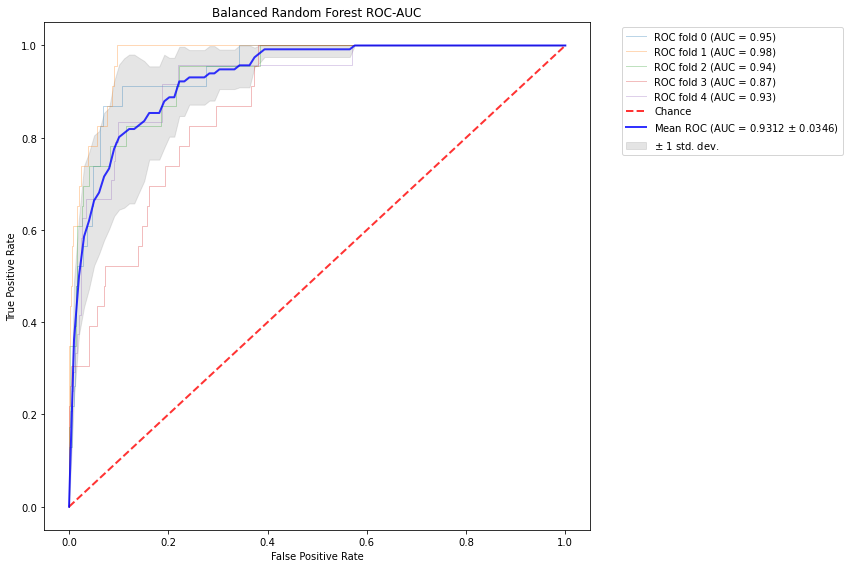

In [7]:
brf_res = roc_plt(X, y, pipe_BRF, "Balanced Random Forest ROC-AUC", seed=seed, create_plot=True)
save_pkl(brf_res, "brf_res_ROC_RFE")

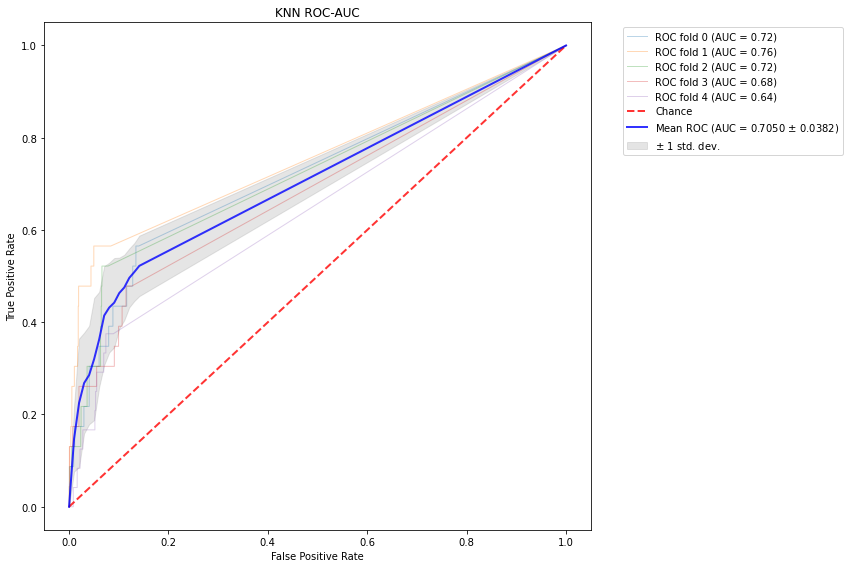

In [8]:
knn_res = roc_plt(X, y, pipe_KNN, "KNN ROC-AUC", seed=seed, create_plot=True)
save_pkl(knn_res, "knn_res_ROC_RFE")

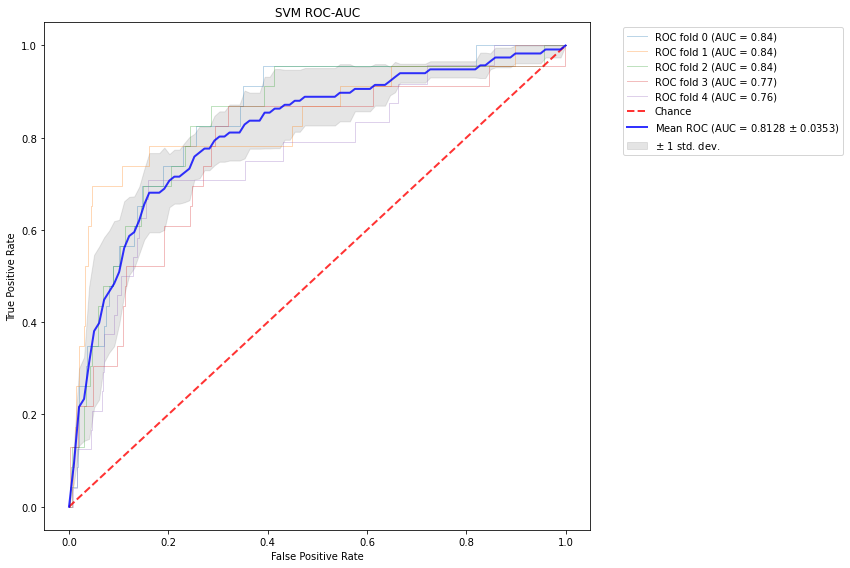

In [9]:
svm_res = roc_plt(X, y, pipe_SVM, "SVM ROC-AUC", seed=seed, create_plot=True)
save_pkl(svm_res, "svm_res_ROC_RFE")

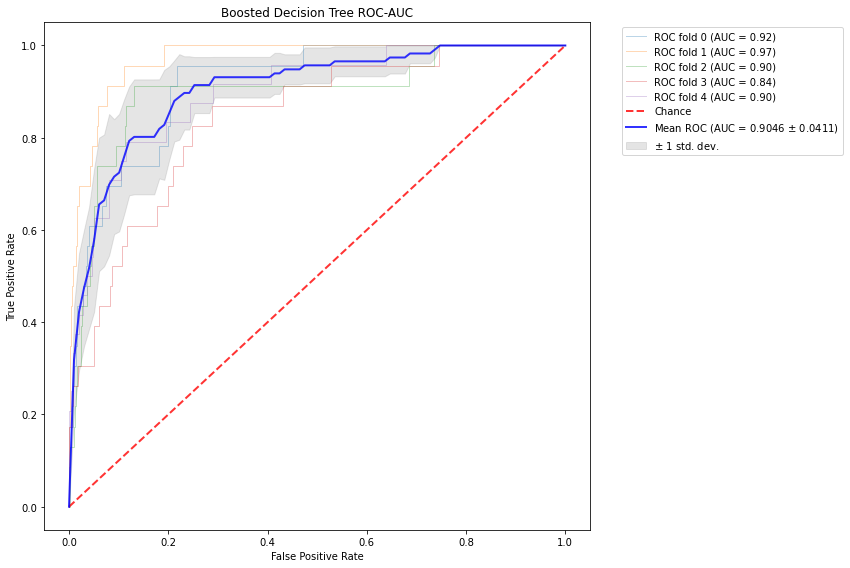

In [10]:
bdt_res = roc_plt(X, y, pipe_BDT, "Boosted Decision Tree ROC-AUC", seed=seed, create_plot=True)
save_pkl(bdt_res, "bdt_res_ROC_RFE")

### Final Plot

In [8]:
k_folds = 5

bdt_res = load_pkl("bdt_res_off_fs")
bdt_res['clf'] = 'Boosted Decision Trees'
svm_res = load_pkl("svm_res_off_fs")
svm_res['clf'] = 'Support Vector Machine'
brf_res = load_pkl("brf_res_off_fs")
brf_res['clf'] = 'Balanced Random Forest'
knn_res = load_pkl("knn_res_off_fs")
knn_res['clf'] = 'K-Nearest Neighbors'

rocauc_res = pd.concat([svm_res, bdt_res, knn_res, brf_res])
rocauc_res['Classifier'] = rocauc_res['clf'] + ' : Auc Score: ' + rocauc_res['mean_auc'].round(4).astype(str)
rocauc_res = rocauc_res.sort_values('mean_auc', ascending=False)

model_names = ['Boosted Decision Trees','Support Vector Machine','Balanced Random Forest','K-Nearest Neighbors','Neural Network']
colors = dict(zip(model_names, sns.color_palette("colorblind",5))) 
colors = {k: colors[k] for k in rocauc_res['clf'].unique().tolist()}

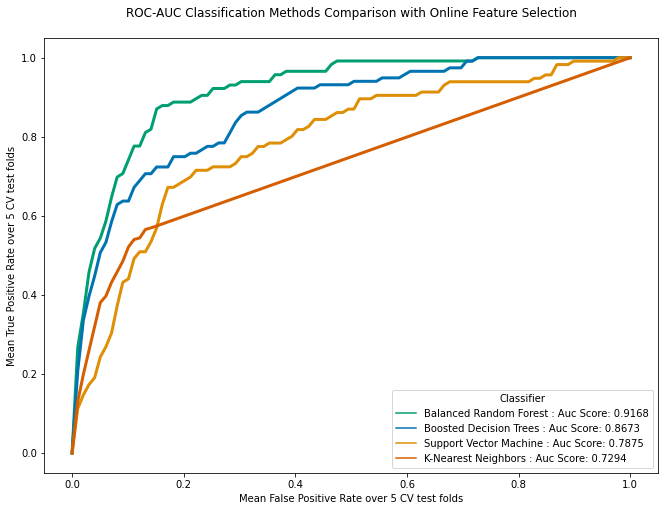

In [9]:
aggregated_roc_plot(rocauc_res, list(colors.values()), 'ROC-AUC Classification Methods Comparison with Online Feature Selection\n', IMG_PATH+'roc_on_fs.pdf')